In [16]:
# 首先安装 MuJoCo（如果还没安装）
# 这会在当前 Jupyter kernel 的 Python 环境中安装


# MuJoCo 测试代码 - 展示基本功能
# MuJoCo 是一个高性能的物理仿真引擎，用于机器人仿真、强化学习等

import mujoco
import mujoco.viewer
import numpy as np
import time

print("✓ MuJoCo 版本:", mujoco.__version__)
print("✓ MuJoCo 已成功导入！")


✓ MuJoCo 版本: 3.2.3
✓ MuJoCo 已成功导入！


In [17]:
# 测试1: 创建一个简单的2D机械臂模型
# 这个模型包含两个关节，可以自由旋转

xml_simple_arm = """
<mujoco>
  <worldbody>
    <!-- 地面 -->
    <geom type="plane" size="2 2 0.1" rgba="0.8 0.8 0.8 1"/>
    <light pos="0 0 3"/>
    
    <!-- 第一个关节（肩部） -->
    <body pos="0 0 0.5">
      <joint type="hinge" axis="0 0 1" name="shoulder" damping="0.1"/>
      <geom type="cylinder" size="0.05 0.1" rgba="1 0 0 1"/>
      
      <!-- 第二个关节（肘部） -->
      <body pos="0.2 0 0">
        <joint type="hinge" axis="0 0 1" name="elbow" damping="0.1"/>
        <geom type="cylinder" size="0.04 0.15" rgba="0 1 0 1"/>
        
        <!-- 末端执行器 -->
        <body pos="0.15 0 0">
          <geom type="sphere" size="0.03" rgba="0 0 1 1"/>
        </body>
      </body>
    </body>
  </worldbody>
  
  <!-- 添加执行器（actuator），这样才能使用 data.ctrl -->
  <actuator>
    <motor joint="shoulder" gear="50"/>
    <motor joint="elbow" gear="30"/>
  </actuator>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml_simple_arm)
data = mujoco.MjData(model)

print("✓ 2D机械臂模型创建成功！")
print(f"  关节数量: {model.njnt}")
print(f"  自由度: {model.nv}")
print(f"  物体数量: {model.nbody}")
print(f"  执行器数量: {model.nu}")  # 控制输入数量
print(f"  data.ctrl 大小: {data.ctrl.shape}")  # 验证控制数组


✓ 2D机械臂模型创建成功！
  关节数量: 2
  自由度: 2
  物体数量: 4
  执行器数量: 2
  data.ctrl 大小: (2,)


In [18]:
# 测试2: 运行仿真并可视化（交互式）
# 这个会打开一个3D窗口，你可以看到机械臂运动

print("正在启动可视化窗口...")
print("提示：关闭窗口后程序会继续")

with mujoco.viewer.launch_passive(model, data) as viewer:
    # 运行仿真循环
    start_time = time.time()
    while viewer.is_running():
        step_start = time.time()
        
        # 简单的控制：让关节摆动
        t = time.time() - start_time
        data.ctrl[0] = 0.5 * np.sin(t)  # 肩部关节
        data.ctrl[1] = 0.3 * np.cos(t * 1.5)  # 肘部关节
        
        # 步进仿真
        mujoco.mj_step(model, data)
        
        # 同步视图
        viewer.sync()
        
        # 控制仿真速度（约60 FPS）
        time_until_next_step = model.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)

print("✓ 仿真完成！")


正在启动可视化窗口...
提示：关闭窗口后程序会继续
✓ 仿真完成！


In [11]:
# 测试3: 创建一个更复杂的场景 - 带重力的球体下落
# 展示物理引擎的碰撞检测和重力效果

xml_physics = """
<mujoco>
  <option timestep="0.01" gravity="0 0 -9.81"/>
  
  <worldbody>
    <light pos="0 0 4"/>
    <geom type="plane" size="2 2 0.1" rgba="0.7 0.7 0.7 1"/>
    
    <!-- 一个会下落的球 -->
    <body pos="0 0 2">
      <freejoint/>
      <geom type="sphere" size="0.1" mass="1" rgba="1 0.5 0 1"/>
    </body>
    
    <!-- 一个盒子 -->
    <body pos="0.5 0 0.3">
      <freejoint/>
      <geom type="box" size="0.15 0.15 0.15" mass="2" rgba="0 0.8 0.8 1"/>
    </body>
  </worldbody>
</mujoco>
"""

model_physics = mujoco.MjModel.from_xml_string(xml_physics)
data_physics = mujoco.MjData(model_physics)

print("✓ 物理场景创建成功！")
print("  包含：球体（橙色）和盒子（青色）")
print("  它们会在重力作用下下落并碰撞地面")


✓ 物理场景创建成功！
  包含：球体（橙色）和盒子（青色）
  它们会在重力作用下下落并碰撞地面


In [13]:
# 运行物理仿真
print("正在运行物理仿真...")
print("提示：关闭窗口后程序会继续")

with mujoco.viewer.launch_passive(model_physics, data_physics) as viewer:
    start_time = time.time()
    while viewer.is_running() and (time.time() - start_time) < 5:  # 运行5秒
        mujoco.mj_step(model_physics, data_physics)
        viewer.sync()
        time.sleep(model_physics.opt.timestep)

print("✓ 物理仿真完成！")


正在运行物理仿真...
提示：关闭窗口后程序会继续
✓ 物理仿真完成！


In [14]:
# 测试4: 获取仿真数据（无需可视化窗口）
# 展示如何在不打开窗口的情况下运行仿真并获取数据

# 重置数据
mujoco.mj_resetData(model, data)

# 运行1000步仿真
positions = []
velocities = []

for i in range(1000):
    # 设置控制输入
    data.ctrl[0] = 0.5 * np.sin(i * 0.01)
    data.ctrl[1] = 0.3 * np.cos(i * 0.015)
    
    # 步进
    mujoco.mj_step(model, data)
    
    # 记录数据
    positions.append(data.qpos.copy())
    velocities.append(data.qvel.copy())

positions = np.array(positions)
velocities = np.array(velocities)

print("✓ 无窗口仿真完成！")
print(f"  记录了 {len(positions)} 个时间步的数据")
print(f"  关节位置范围: {positions.min():.3f} ~ {positions.max():.3f}")
print(f"  关节速度范围: {velocities.min():.3f} ~ {velocities.max():.3f}")


✓ 无窗口仿真完成！
  记录了 1000 个时间步的数据
  关节位置范围: -0.110 ~ 56.254
  关节速度范围: -70.302 ~ 132.271


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17748\931534778.py:25: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17748\931534778.py:25: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17748\931534778.py:25: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17748\931534778.py:25: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17748\931534778.py:25: UserWarning: Glyph 33410 (\N{CJK UNIFIED IDEOGRAPH-8282}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17748\931534778.py:25: UserWarning: Glyph 3

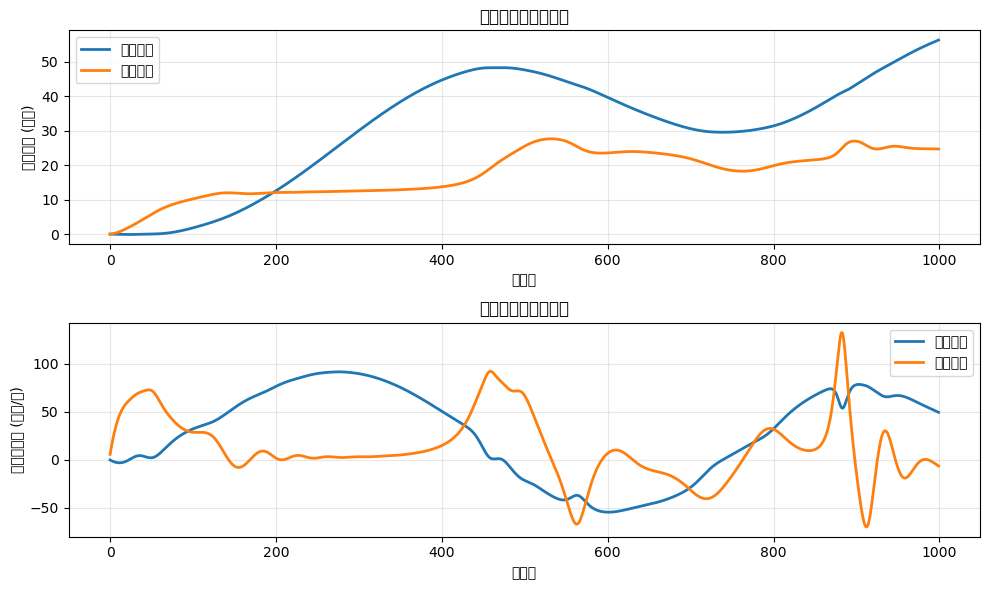

✓ 数据可视化完成！


In [15]:
# 测试5: 可视化仿真数据
import matplotlib.pyplot as plt

# 绘制关节位置随时间的变化
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

time_steps = np.arange(len(positions))

ax1.plot(time_steps, positions[:, 0], label='肩部关节', linewidth=2)
ax1.plot(time_steps, positions[:, 1], label='肘部关节', linewidth=2)
ax1.set_xlabel('时间步')
ax1.set_ylabel('关节角度 (弧度)')
ax1.set_title('关节位置随时间变化')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(time_steps, velocities[:, 0], label='肩部速度', linewidth=2)
ax2.plot(time_steps, velocities[:, 1], label='肘部速度', linewidth=2)
ax2.set_xlabel('时间步')
ax2.set_ylabel('关节角速度 (弧度/秒)')
ax2.set_title('关节速度随时间变化')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ 数据可视化完成！")


## MuJoCo 功能总结

通过以上测试，MuJoCo 可以：

1. **创建机器人模型** - 定义关节、连杆、传感器等
2. **物理仿真** - 重力、碰撞、摩擦等物理效果
3. **实时可视化** - 3D交互式窗口查看仿真
4. **数据采集** - 获取位置、速度、力等数据
5. **控制仿真** - 通过控制输入驱动机器人
6. **高性能** - 适合大规模仿真和强化学习

**应用场景：**
- 🤖 机器人运动规划和控制
- 🎮 游戏物理引擎
- 🧠 强化学习训练环境
- 📊 生物力学仿真
- 🔬 科学研究
